In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.fft import fft, ifft
from scipy.signal import periodogram
import ordpy 
import statsmodels.api as sm
from scipy.signal import butter,filtfilt
from matplotlib.pyplot import figure
from os import listdir
from os.path import isfile, join
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import pickle
import re
from matplotlib.pyplot import MultipleLocator
import seaborn as sns

In [4]:
D1_data=pd.read_pickle('../data/dataset/D1_puregooddata_25032023.pkl')

In [5]:
class pain_monitering_D1:
    def __init__(self,PID):
        self.PID=PID
        self.D1_rating=[]
        self.D1_time=[]
        self.D1_prediction=-1
        self.D1_confidence=-1
    def __str__(self):
        print("participant: "+self.PID)
        print("Day 1 rating: "+str(len(self.D1_rating))+" sessions")
        print("Day 1 timing: "+str(len(self.D1_time))+" sessions")
        print("Day 1 prediction: "+ str(self.D1_prediction))
        print("Day 1 confidence: "+ str(self.D1_confidence))
        return ""
    def insert_rating_time(self,rating_per_session,time_per_session):
        self.D1_rating.append(rating_per_session)
        self.D1_time.append(time_per_session)
    def update_prediction_confidence(self,pred,conf):
        self.D1_prediction=pred
        self.D1_confidence=conf

In [6]:
Day1_participant_list=[]
for i,pid in enumerate(D1_data['PID']):
    if i%3==0:
        partcipant=pain_monitering_D1(pid)
        partcipant.insert_rating_time(D1_data['rating'][i],D1_data['time'][i])
        partcipant.update_prediction_confidence(D1_data['prediction'][i],D1_data['confidence'][i])
        Day1_participant_list.append(partcipant)
    else:
        Day1_participant_list[i//3].insert_rating_time(D1_data['rating'][i],D1_data['time'][i])
print(str(len(Day1_participant_list))+" participants")

81 participants


mean: 0.018125524610370817
frequency: 55.17081692784956
0<gap<=0.02: 1117512 gaps
0.02<gap<=0.05: 255145 gaps
0.05<gap<=0.1: 6128 gaps
0.1<gap<=0.2: 146 gaps
0.2<gap<=0.5: 121 gaps
0.5<gap<=1: 67 gaps
1<gap<=5: 59 gaps
5<gap<=10: 12 gaps
10<gap<=20: 16 gaps
gap>20: 8 gaps


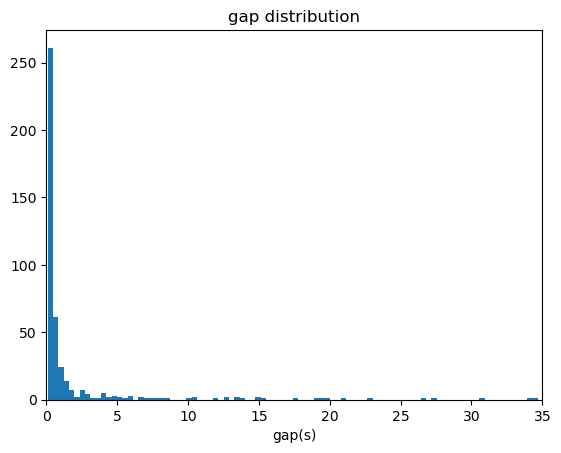

In [7]:
whole_list=[]
gap_list=[]
for part in Day1_participant_list:
    for i in range(3):
        for j in range(len(part.D1_time[i])-1):
            whole_list.append(part.D1_time[i][j+1]-part.D1_time[i][j])
mean_gap=sum(whole_list)/len(whole_list)
print("mean: "+str(mean_gap))
print("frequency: "+str(1/mean_gap))
gapgroup_list=[[],[],[],[],[],[],[],[],[],[]]
for gap in whole_list:
    if 0<gap<=0.02:
        gapgroup_list[0].append(gap)
    elif 0.02<gap<=0.05:
        gapgroup_list[1].append(gap)
    elif 0.05<gap<=0.1:
        gapgroup_list[2].append(gap)
    elif 0.1<gap<=0.2:
        gapgroup_list[3].append(gap)
    elif 0.2<gap<=0.5:
        gapgroup_list[4].append(gap)
    elif 0.5<gap<=1:
        gapgroup_list[5].append(gap)
    elif 1<gap<=5:
        gapgroup_list[6].append(gap)
    elif 5<gap<=10:
        gapgroup_list[7].append(gap)
    elif 10<gap<=20:
        gapgroup_list[8].append(gap)
    else:
        gapgroup_list[9].append(gap)
for i,gap in enumerate(gapgroup_list):
    if i==0:
        print("0<gap<=0.02: ",end='')
    elif i==1:
        print("0.02<gap<=0.05: ",end='')
    elif i==2:
        print("0.05<gap<=0.1: ",end='')
    elif i==3:
        print("0.1<gap<=0.2: ",end='')
    elif i==4:
        print("0.2<gap<=0.5: ",end='')
    elif i==5:
        print("0.5<gap<=1: ",end='')
    elif i==6:
        print("1<gap<=5: ",end='')
    elif i==7:
        print("5<gap<=10: ",end='')
    elif i==8:
        print("10<gap<=20: ",end='')
    else:
        print("gap>20: ",end="")
    print(str(len(gap))+" gaps")
for gap in whole_list:
    if gap >0.1:
        gap_list.append(gap)

plt.xlim(0,35)
plt.xlabel("gap(s)")
plt.title("gap distribution")
plt.hist(gap_list,bins=100)
plt.show()

# standard=2*sum(whole_list)/len(whole_list)
# for gap in whole_list:
#     if gap>=standard:
#         gap_list.append(gap)
# df=pd.DataFrame(gap_list)
# df.plot(kind="hist",color="steelblue",edgecolor="black",density=True)
# df.plot(kind="kde",color="red")
# plt.xlabel("gap")
# plt.title("gap distribution")
# x_major_locator=MultipleLocator(0.05)
# ax=plt.gca()
# ax.xaxis.set_major_locator(x_major_locator)
# plt.xlim(0,0.4)
# plt.show()

+ two solution to deal with those gaps
    + interpolate data at short gaps
    + separate data at long gaps
+ set a boundary for short and long gaps
    standard:
    + how many people have long gaps, how many gaps they have.
    + how many trials after separation (mean and distribution)
    + how long is each trial (mean and distribution? shortest?)

In [8]:
# boundary for short and long gaps (unit: second)
gap_boundary=10

In [9]:
part_split_longgap=[]
for part in Day1_participant_list:
    part_new=pain_monitering_D1(part.PID)
    part_new.update_prediction_confidence(part.D1_prediction,part.D1_confidence)
    for Session_i,timelist in enumerate(part.D1_time):
        start_label=0
        for time_j in range(len(timelist)-1):
            gap=timelist[time_j+1]-timelist[time_j]
            if gap > gap_boundary:
                part_new.insert_rating_time(part.D1_rating[Session_i][start_label:time_j+1],part.D1_time[Session_i][start_label:time_j+1])
                start_label=time_j+1
        part_new.insert_rating_time(part.D1_rating[Session_i][start_label:len(timelist)],part.D1_time[Session_i][start_label:len(timelist)])
    part_split_longgap.append(part_new)
filename = '../data/dataset/D1data_class_10sgap.pkl'
pickle.dump(part_split_longgap, open(filename, 'wb'))

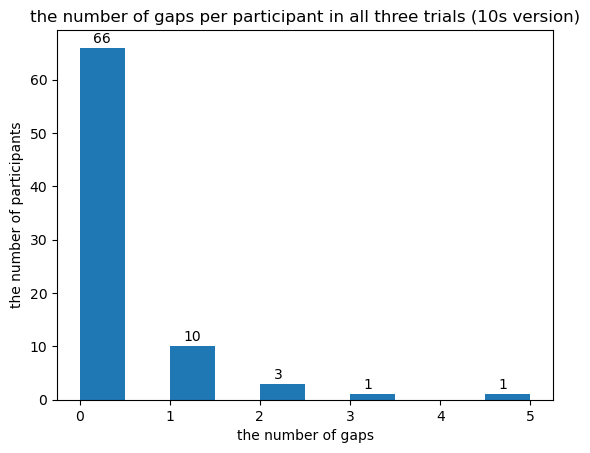

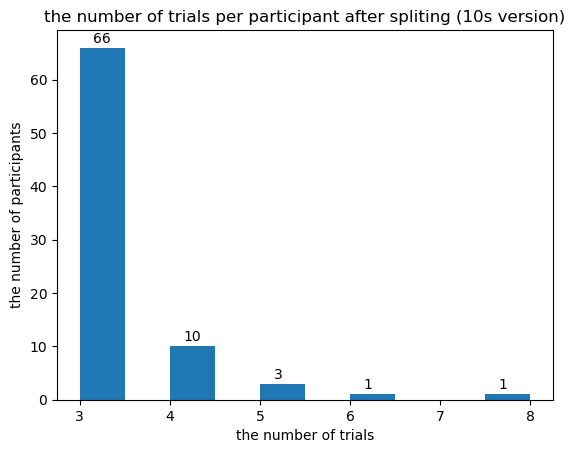

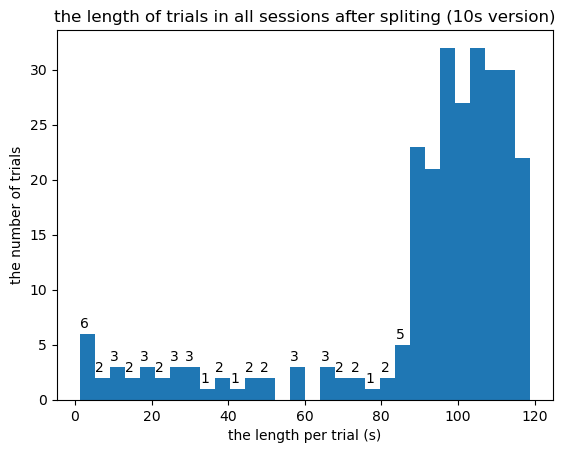

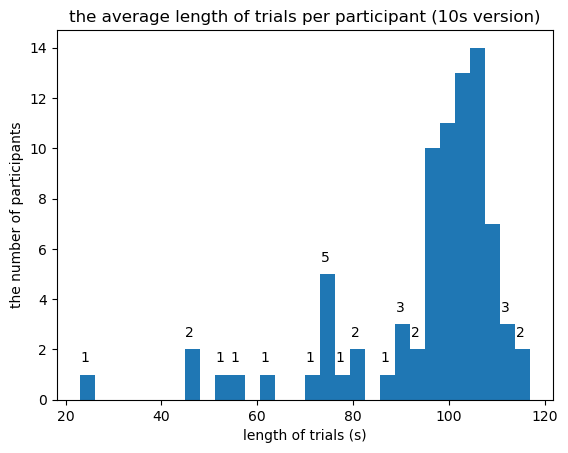

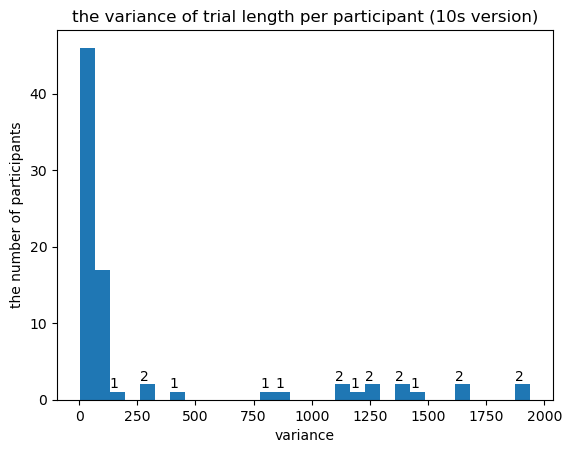

In [10]:
gap_count_perpart=[]
trial_count_perpart=[]
trial_length_perpart=[]
trial_mean_length_perpart=[]
trial_var_length_perpart=[]
for i,part in enumerate(part_split_longgap):
    trial_count_perpart.append(len(part.D1_time))
    gap_count_perpart.append(len(part.D1_time)-3)
    length_list=[]
    for j,timelist in enumerate(part.D1_time):
        length_list.append(timelist[-1]-timelist[0])
    trial_length_perpart.extend(length_list)
    trial_mean_length_perpart.append(sum(length_list)/len(length_list))
    trial_var_length_perpart.append(np.var(np.array(length_list)))

####### distribution of the amount of gap each participant
plt.xlabel("the number of gaps")
plt.ylabel("the number of participants")
plt.title("the number of gaps per participant in all three trials (10s version)")
arr = plt.hist(gap_count_perpart)
for i in range(10):
    if arr[0][i]!=0:
        plt.text(arr[1][i]+0.15,arr[0][i]+1,str(int(arr[0][i])))
plt.show()
# ####### distribution of the amount of trial each participant
plt.xlabel("the number of trials")
plt.ylabel("the number of participants")
plt.title("the number of trials per participant after spliting (10s version)")
arr=plt.hist(trial_count_perpart)
for i in range(10):
    if arr[0][i]!=0:
        plt.text(arr[1][i]+0.15,arr[0][i]+1,str(int(arr[0][i])))
plt.show()
# ####### distribution of the length of each trial
plt.title("the length of trials in all sessions after spliting (10s version)")
plt.xlabel("the length per trial (s)")
plt.ylabel("the number of trials")
arr=plt.hist(trial_length_perpart,bins=30)
for i in range(30):
    if 0<arr[0][i]<10:
        plt.text(arr[1][i]+0.1,arr[0][i]+0.5,str(int(arr[0][i])))
plt.show()
####### distribution of the mean length of participant
plt.title("the average length of trials per participant (10s version)")
plt.xlabel("length of trials (s)")
plt.ylabel("the number of participants")
arr=plt.hist(trial_mean_length_perpart,bins=30)
for i in range(30):
    if 0<arr[0][i]<6:
        plt.text(arr[1][i]+0.1,arr[0][i]+0.5,str(int(arr[0][i])))
plt.show()
# ####### distribution of the variance per participant
plt.title("the variance of trial length per participant (10s version)")
plt.xlabel("variance")
plt.ylabel("the number of participants")
arr=plt.hist(trial_var_length_perpart,bins=30)
for i in range(30):
    if 0<arr[0][i]<10:
        plt.text(arr[1][i]+0.1,arr[0][i]+0.5,str(int(arr[0][i])))
plt.show()

In [25]:
gap_num_boundary=3
trial_len_boundary=10

In [27]:
# remove participants who have at least three long gaps (It is based on our discussion both the number of trials and the lenght of trials analysis above)
# remove trials which is shorter than 10s
part_split_removepart=[part for part in part_split_longgap if len(part.D1_rating)<gap_num_boundary+3]
for part in part_split_removepart:
    new_time_list=[]
    new_rating_list=[]
    for j,timelist in enumerate(part.D1_time):
        if timelist[-1]-timelist[0]>trial_len_boundary:
            new_time_list.append(timelist)
            new_rating_list.append(part.D1_rating[j])
    part.D1_time=new_time_list
    part.D1_rating=new_rating_list

+ 1 gap
    + 62b33a5e37ff2b46fba512e3
    + 615c453806ba1a372800c832
    + 5f69f8a030340e0162eb8c76
    + 61268bfae35dcb011f6081b5
    + 5c377642bc6444000133aae9
    + 63066fd662ffe3dc553bb8a3
    + 5b91a7f012fa940001a30997
    + 60deb63539c4fb727e50bd52
    + 61687ebcd2a35ffb762d1928
    + 63de1588e290889caeb49561
+ 2 gap
    + 6310ccbda708843d8c079b6d (1 short trial)
    + 5ecd36302b4d3c05d4cc1ba2 (1 short trial)
    + 63468b3bd07050877a6beb11 (1 short trial)

+ 3 gap
    + 613a415ae2f1292f97385a12 (2 short trials)

+ 5 gap
    + 63d79cb221c143d2c8fdc3f6 (3 short trials)

In [28]:
PID_list=[]
rating_list=[]
time_list=[]
prediction_list=[]
confidence_list=[]
for part in part_split_removepart:
    PID_list.append(part.PID)
    rating_list.append(part.D1_rating)
    time_list.append(part.D1_time)
    prediction_list.append(part.D1_prediction)
    confidence_list.append(part.D1_confidence)
df_D1D2 = pd.DataFrame({'PID': PID_list,
                   'rating': rating_list,
                   'time': time_list,
                   'prediction': prediction_list,
                   'confidence': confidence_list})
df_D1D2.to_pickle("../data/dataset/D1_puregooddata_split_31032023.pkl")

In [38]:
df=pd.read_pickle("../data/dataset/D1_puregooddata_split_31032023.pkl")

11
11
